# Muller plot

-------

Muller plots are an intuitive visualisation of a tree that utilises the unused y-axis of phylogenetic trees to display the frequency of a lineage over time. The relationships between lineages are visualised as nesting of frequencies. Depending on how frequencies are computed Muller plots can make things apparent that weren't before when data were visualised as trees.

In this example notebook we'll do two examples. One is an influenza B virus dataset where frequencies are computed using augur (the pipeline nextstrain uses to process data) which gives us normalised and smoothed trajectories of descendant sequence counts for nodes. These get computed for every node so in order to reduce clutter in the Muller plot we'll reduce the tree down to only a couple of specified nodes using a custom `skeleton_tree` function.

The other example is a small handmade tree with frequencies that are unique to a branch (i.e. frequency values correspond to the branch itself but do not include its descendants), where we'll sum the frequencies across offspring. We'll then plot the Muller plot with both unnormalised and normalised frequencies.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

from Bio import Phylo
import numpy as np

import glob,os,copy,requests
from io import StringIO

import baltic as bt
from augur import frequencies,frequency_estimators

# address='https://raw.githubusercontent.com/evogytis/fluB/master/data/mcc%20trees/InfB_NPt_ALLs1.mcc.tre' ## address of example tree
address='https://raw.githubusercontent.com/evogytis/fluB/master/data/mcc%20trees/InfB_PAt_ALLs1.mcc.tre' ## address of example tree

fetch_tree = requests.get(address) ## fetch tree
treeFile=StringIO(fetch_tree.text) ## stream from repo copy

ll=bt.loadNexus(treeFile,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file

ll.treeStats()
print('Done!')


Tree height: 29.500153
Tree length: 458.766950
strictly bifurcating tree
annotations present

Numbers of objects in tree: 903 (451 nodes and 452 leaves)

Done!


### Muller plot code

This cell defines the function used to plot Muller plots. Its operation is quite simply - it traverse the tree, clips frequencies to the time between when they first appear and are last seen, computes the padding available between offspring frequencies and plots them, with normalisation if necessary.

In [2]:
def clip_freq(ys):
    """
    Clip a list of frequencies to the first non-zero and the last non-zero values.
    """
    if sum(ys)==0.0: return []
    xs=range(len(ys))
    try:
        start=next((i for i, y in enumerate(ys) if y), None)
        end=len(xs)-next((i for i, y in enumerate(ys[::-1]) if y), None)
    except:
        print(xs,ys)
        
    if start==0: start=1
    reindex=xs[start-1:end+1]
    return reindex

from collections import Counter

def draw(ax,node,size,timeline,bottom=None,facecolour='lightgrey',edgecolour='k',level=None,normalise=None):
    """
    Plot a Muller plot on ax starting from a node and accessing its frequency using the size function along a timeline grid.
    """
    
    if level==None: level=1
    
    ys=size(node) ## returns values of a node over time
    if normalise: ## if normalise function available - normalise frequencies
        ys=normalise(ys)
    
    bottom=[0-y/2 for y in ys] if bottom==None else bottom ## if no bottom provided - compute it 
    
    xs=range(len(ys)) ## indices of frequencies
    xx=clip_freq(ys) ## reindex frequencies to clip zeroes at the beginning and end
    
    fc=facecolour(node) if callable(facecolour) else facecolour ## get colours
    ec=edgecolour(node) if callable(edgecolour) else edgecolour
    
    clipped_timeline=[timeline[t] for t in xx]
    clipped_bottom=[bottom[t] for t in xx]
    clipped_values=[bottom[t]+ys[t] for t in xx]
    
    ax.fill_between(clipped_timeline,clipped_bottom,clipped_values,facecolor=fc,
                    edgecolor=ec,alpha=1.0,zorder=level) ## plot frequency
    
    if node.is_node(): ## if node has children
        children=[ch for ch in node.children if (ch.is_node() or size(ch))] ## children of node
        clipped_children=[list(clip_freq(size(ch))) for ch in children] ## clip frequencies of child
        clipped_freqs=Counter(sum(clipped_children,[])) ## count how many timeline indices are left
        
        N_children=[clipped_freqs[t]+1 if clipped_freqs[t]>0 else 1 for t in xs] ## count+1 of indices = number of children at any point
        
        children_sum=[sum([size(ch)[t] for ch in children]) for t in xs] ## total frequency of children
        
        if normalise:
            children_sum=normalise(children_sum) ## if normalise available - normalise child frequencies
            
        available_space=[(ys[t]-children_sum[t]) for t in xs] ## node frequency - all children frequencies = padding space left
        
        unique_space=[available_space[t]/N_children[t] for t in xs] ## how much padding to add
        
        temp_bottom=bottom ## start with bottom
    
        for c,child in enumerate(children): ## iterate over children
            child_freq=clip_freq(size(child)) ## clip child frequencies
            
            padded_bottom=[temp_bottom[t]+unique_space[t] if t in child_freq else temp_bottom[t] for t in xs] ## pad bottom with space available, if a child is present
            
            temp_bottom=draw(ax,child,size,timeline,padded_bottom,facecolour=facecolour,
                             edgecolour=edgecolour,level=level+1,normalise=normalise) ## draw frequency for each child, padding as you go
        
    return [bottom[t]+ys[t] for t in xs] ## new bottom is bottom+this node's values

### augur clade frequencies

This cell will convert the baltic tree into a BioPython tree on which augur clade frequencies can be computed.

In [3]:
tips=[k.name for k in ll.Objects if k.branchType=='leaf'] ## get tip names
tipDates=[k.split('_')[-1] for k in tips] ## isolate collection date from tip name
dates=[bt.decimalDate(k,variable=True) for k in tipDates] ## convert dates into decimal dates

tr = Phylo.read(StringIO(ll.toString()), "newick") ## create a Bio.Phylo tree from the baltic tree

for k in ll.Objects:
    if k.length<0.0:
        k.length=0.0 ## convert negative branch lengths to 0.0

for n,nd in enumerate(tr.get_terminals()):
    if hasattr(nd,'attr')==False:
        setattr(nd,'attr',{})
    nd.attr['num_date'] = bt.decimalDate(nd.name.split('_')[-1],variable=True) ## assign collection date to Bio.Phylo tips

pivots = np.array(frequency_estimators.make_pivots(200,np.array(dates))) ## create time grid for clade frequencies
bfq=frequencies.tree_frequencies(tr,min_clades=50,node_filter=None,pivots=pivots,verbose=False) ## create a frequencies object

bfq.estimate_clade_frequencies() ## estimate smoothed trajectories

for n,nd in enumerate(ll.traverse_tree(include_condition=lambda k:True)): ## frequencies are estimated in traversal order
    if nd.is_node():
        nd.traits['cf']=bfq.frequencies[n] ## assign frequency vector to node

### Plotting augur frequencies

Real trees are large and clade frequencies are computed for either all or a small number of branches with augur. Traversing trees where some branches don't have frequency vectors would cause plotting issues, so in order to make everything look neat we'll reduce the tree to just the nodes whose frequencies we care about while preserving their ultimate relationships.

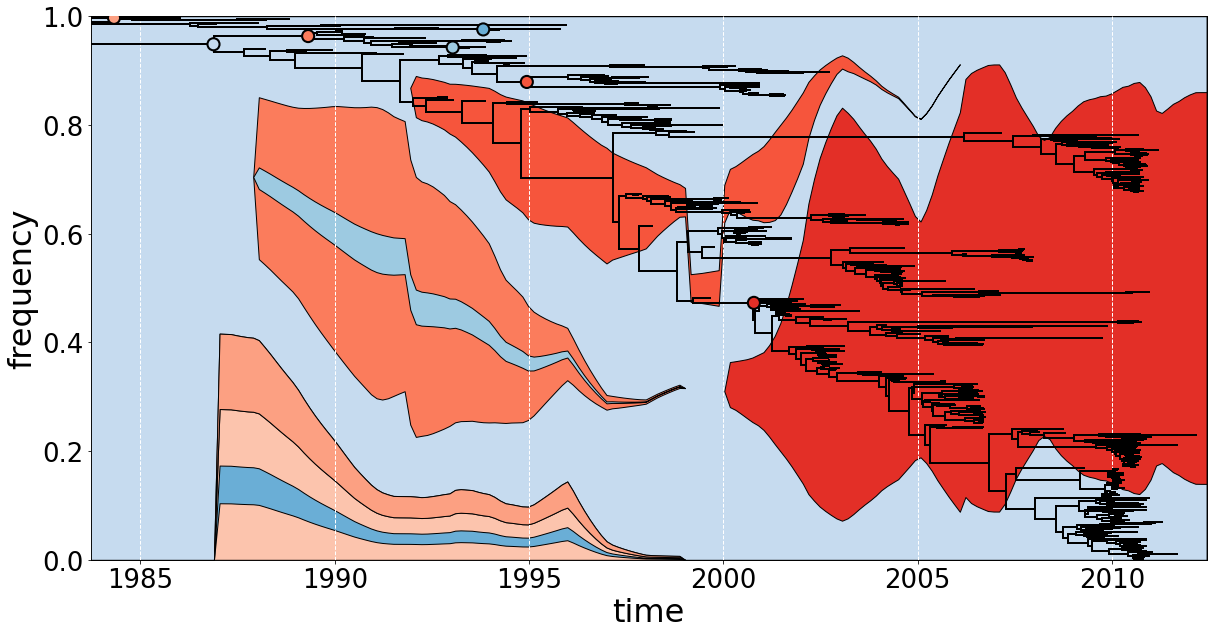

In [4]:
def skeleton_tree(nodes,tree):
    """
    Reduce the tree to specified nodes, preserving their relative relationships and all the tips. 
    """
    skeleton=copy.deepcopy(tree) ## deepcopy tree
    indices=set([n.index for n in nodes]) ## index nodes we want to keep
    relations={} ## will map node to parent
    for k in [nd for nd in skeleton.getInternal() if nd.index in indices]+skeleton.getExternal(): ## iterate over nodes we want to keep and all tips
        cur_node=k
        while cur_node.parent and cur_node.parent.index not in indices: ## descend to root for as long as a parental node we want to keep is encountered
            cur_node=cur_node.parent
        else:
            relations[k]=cur_node.parent ## remember (simplified) relationship
    
    remove=[]
    for k in skeleton.Objects: ## iterate over all branches
        if k not in relations and k not in list(relations.values()): ## branch is not one we want to keep
            remove.append(k) ## remember to remove
        
    for r in remove:
        skeleton.Objects.remove(r) ## remove unwanted nodes
        
    for k in skeleton.getInternal():
        k.children=[] ## reset children of all nodes
    
    for k in relations: ## iterate over nodes we kept
        parent=relations[k] ## get the node's new parent
        
        if parent: parent.children.append(k) ## parent is available - add node to parent's children
        k.parent=parent ## assign parent
        
    for k in skeleton.Objects:
        k.length=k.height-k.parent.height if k.parent else 0.0 ## set new branch lengths now that a lot of intervening branches have been removed
        
    return skeleton

fig = plt.subplots(figsize=(20,10),facecolor='w')

gs = gridspec.GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

significant=lambda k: [len(ch.leaves)>70 for ch in k.children if ch.is_node()].count(True)>=2 or k==ll.root or ('PB1' in k.parent.traits and k.traits['PB1']!=k.parent.traits['PB1']) ## will highlight nodes with children that are nodes themselves, each with >70 descendant tips, or root, or mismatched PB1 states

target=lambda k: k.is_node() and significant(k)

timeline=pivots

################ colour assignment
keep=[]

colours={}
Vs=1
Ys=1
for k in sorted(ll.getBranches(target),key=lambda w: w.height): ## get colours for each clade
    keep.append(ll.traverse_tree(k)[0])
    if k.traits['PB1']=='V':
        c=mpl.cm.Reds(Vs/9)
        colours[k.index]=c
        Vs+=1
    elif k.traits['PB1']=='Y':
        c=mpl.cm.Blues(Ys/8)
        colours[k.index]=c
        Ys+=1
        
simple_ll=skeleton_tree(ll.getBranches(target),ll) ## reduce the tree to certain nodes, preserving relationships but keeping all tips
################

size=lambda k: k.traits['cf'] if 'cf' in k.traits else None ## access frequency values
facecolour=lambda k: colours[k.index] if k.index in colours else 'lightgrey' ## get colour

draw(ax,simple_ll.root,size,timeline,bottom=[0 for x in timeline],facecolour=facecolour,edgecolour='k') ## draw Muller plot

x_attr=lambda k: k.absoluteTime ## plot in absolute time
y_attr=lambda k: k.y/ll.ySpan ## constrain tree y dimension to be between 0 and 1

ll.plotTree(ax,x_attr=x_attr,y_attr=y_attr,zorder=100000) ## plot tree
ll.plotPoints(ax,target=target,x_attr=x_attr,y_attr=y_attr,size=100,colour=facecolour,zorder=100000) ## plot preserved nodes

ax.vlines(ax.get_xticks(),0,1,color='w',ls='--',lw=1,zorder=1000) ## add vertical lines for dates
ax.set_xlabel('time',size=32)
ax.set_ylabel('frequency',size=32)
ax.tick_params(labelsize=26)
ax.set_xlim(min(timeline),max(timeline))
ax.set_ylim(0,1)

plt.show()

This cell just shows the tree that is the source of Muller plot frequencies.

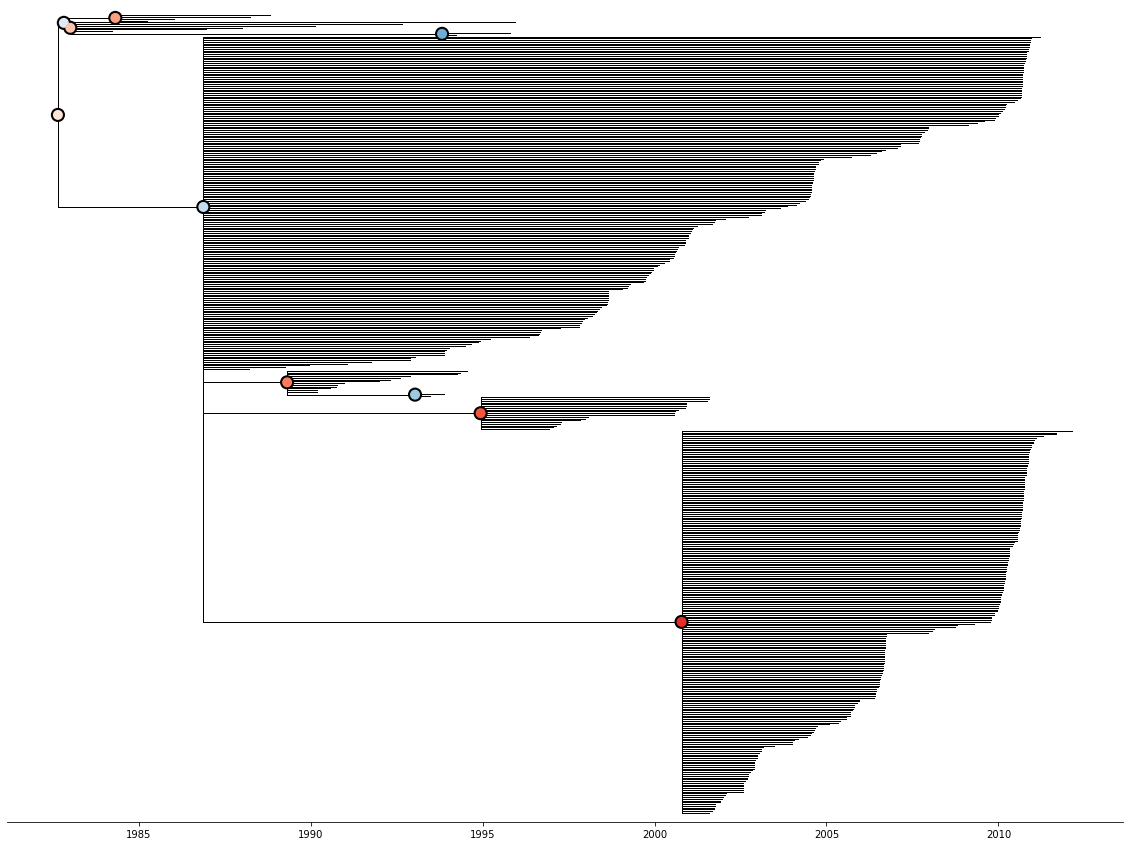

In [5]:
fig = plt.subplots(figsize=(20,15),facecolor='w')

gs = gridspec.GridSpec(1, 1,hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])

skeleton=skeleton_tree(ll.getBranches(target),ll)
skeleton.sortBranches()

x_attr=lambda k: k.absoluteTime
y_attr=lambda k: k.y/ll.ySpan

skeleton.plotTree(ax,x_attr=x_attr,y_attr=y_attr,width=1,zorder=100000)
skeleton.plotPoints(ax,target=lambda k: k.index in [w.index for w in ll.getBranches(target)],x_attr=x_attr,y_attr=y_attr,size=100,colour=facecolour,zorder=100000)

ax.set_yticks([])
ax.set_yticklabels([])
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_ylim(-0.01,1.01)

plt.show()

### Custom frequencies

If you have computed frequencies using some other method other than augur's clade frequencies or you're working with counts rather than frequencies this code will help you plot your data - normalised or unnormalised.



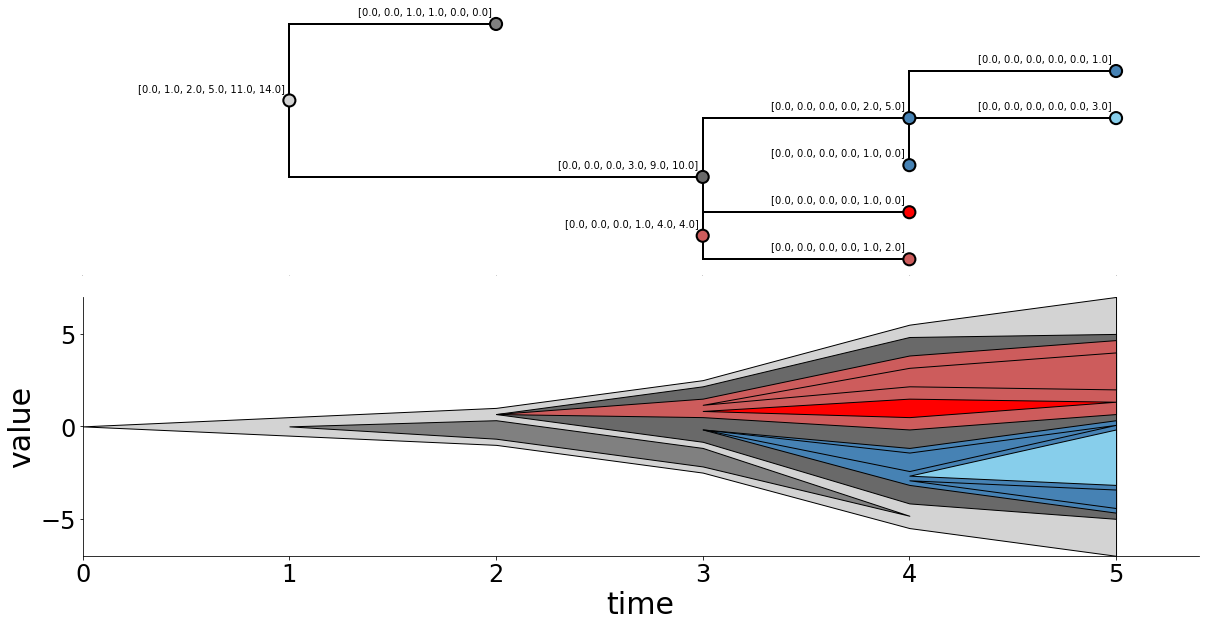

In [6]:
def sum_values(node,attribute):
    """
    Collect a node's children attributes, add to parent's attribute (assumes it's a list).
    """
    if node.is_node(): ## has children
        for child in node.children: ## iterate over children
            values=sum_values(child,attribute) ## call on children
            node.traits[attribute]=[cur_val+ch_val for cur_val,ch_val in zip(node.traits[attribute],values)] ## add children values to current node
            
    return node.traits[attribute] ## return node's values
            

example='((("A1"[&freqs={0,0,0,0,1,0},fc="red"],"A2"[&freqs={0,0,0,0,1,2},fc="indianred"])[&freqs={0,0,0,1,2,2},fc="indianred"],("B1"[&freqs={0,0,0,0,0,1},fc="steelblue"],"B2"[&freqs={0,0,0,0,0,3},fc="skyblue"],"B3"[&freqs={0,0,0,0,1,0},fc="steelblue"])[&freqs={0,0,0,0,1,1},fc="steelblue"])[&freqs={0,0,0,2,3,1},fc="dimgrey"],"C"[&freqs={0,0,1,1,0,0},fc="grey"])[&freqs={0,1,1,1,2,4},fc="lightgrey"];' ## small tree with node labels that are counts and colours

ll=bt.make_tree(example) ## turn string into baltic tree
sum_values(ll.root,'freqs') ## add children's values to parent's value

fig = plt.subplots(figsize=(20,10),facecolor='w')

gs = gridspec.GridSpec(2, 1,hspace=0.1,wspace=0.0)
ax = plt.subplot(gs[0])

for k in ll.Objects: ## iterate over branches
    for i,x in enumerate(k.traits['freqs']): ## iterate over "time points"
        if x>0 and k.height==None: ## first time point where frequency is not zero and height not set yet
            k.height=i ## branch height is first non-zero frequency value
            
for k in ll.Objects:
    k.length=k.height-k.parent.height ## length is difference in heights
    
ll.sortBranches()
ll.plotTree(ax) ## plot tree
ll.plotPoints(ax,target=lambda k: True, colour=lambda k: k.traits['fc'],size=100) ## plot points for every branch
ll.addText(ax,x_attr=lambda k: k.height-0.02,y_attr=lambda k: k.y+0.2,target=lambda k: True,text=lambda k: k.traits['freqs'],ha='right') ## add text that shows the frequency of each branch

ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(size=0,labelsize=0)
[ax.spines[loc].set_visible(False) for loc in ax.spines]

ax2 = plt.subplot(gs[1],sharex=ax)

size=lambda k: k.traits['freqs'] ## get frequencies of branch
facecolour=lambda k: k.traits['fc'] ## get colour of branch

draw(ax2,ll.root,size,range(6),facecolour=facecolour,edgecolour='k') ## draw Muller plot

[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['left','bottom']]
ax2.tick_params(labelsize=24)
ax2.set_ylabel('value',size=30)
ax2.set_xlabel('time',size=30)

ax2.set_xlim(0,5.4)
ax2.set_ylim(-7,7)

plt.show()

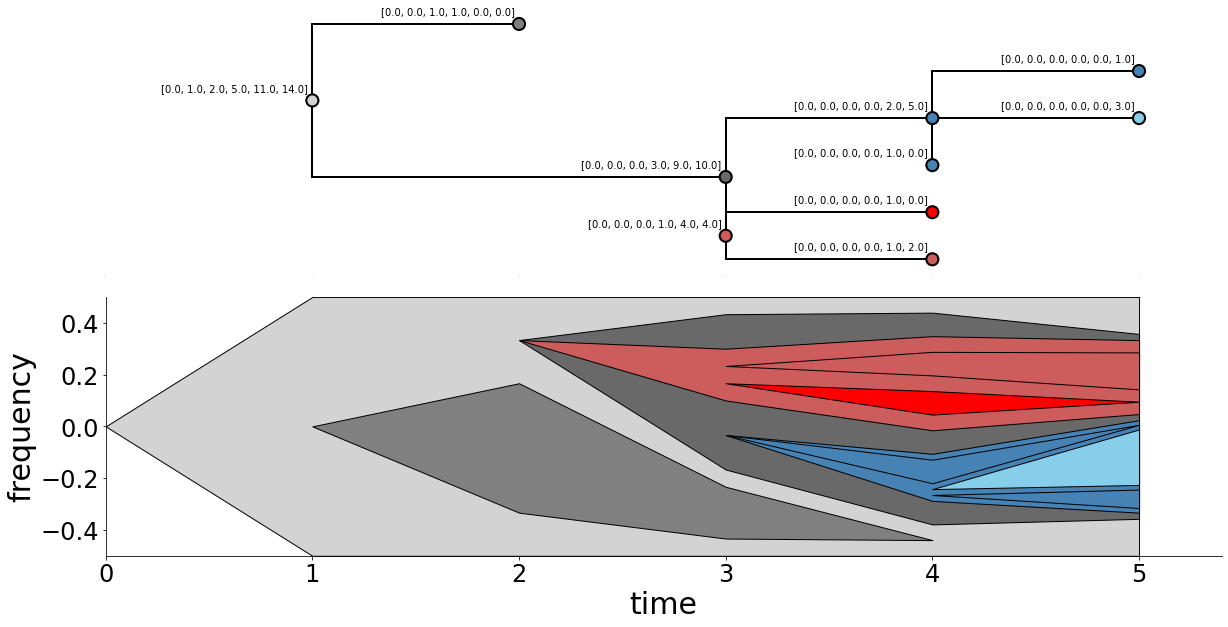

In [7]:
## repeat same procedure as before

ll=bt.make_tree(example)
sum_values(ll.root,'freqs')

fig = plt.subplots(figsize=(20,10),facecolor='w')

gs = gridspec.GridSpec(2, 1,hspace=0.1,wspace=0.0)
ax = plt.subplot(gs[0])

for k in ll.Objects:
    for i,x in enumerate(k.traits['freqs']):
        if x>0 and k.height==None:
            k.height=i
            
for k in ll.Objects:
    k.length=k.height-k.parent.height
    
ll.sortBranches()
ll.plotTree(ax)
ll.plotPoints(ax,target=lambda k: True, colour=lambda k: k.traits['fc'],size=100)
ll.addText(ax,x_attr=lambda k: k.height-0.02,y_attr=lambda k: k.y+0.2,target=lambda k: True,text=lambda k: k.traits['freqs'],ha='right')

ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(size=0,labelsize=0)
[ax.spines[loc].set_visible(False) for loc in ax.spines]

ax2 = plt.subplot(gs[1],sharex=ax)

size=lambda k: k.traits['freqs']
facecolour=lambda k: k.traits['fc']
normalise=lambda ys: [y/Max if Max!=0.0 else 0.0 for y,Max in zip(ys,ll.root.traits['freqs'])] ## normalise values of all frequencies to be between 0 and 1 by dividing by root's frequency

draw(ax2,ll.root,size,range(6),facecolour=facecolour,edgecolour='k',normalise=normalise) ## this time we're adding normalisation

[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['left','bottom']]
ax2.tick_params(labelsize=24)
ax2.set_ylabel('frequency',size=30)
ax2.set_xlabel('time',size=30)

ax2.set_xlim(0,5.4)
ax2.set_ylim(-0.5,0.5)

plt.show()